In [11]:
import sys
sys.path.append("../")

In [25]:
import os 
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import importlib
import random
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1 import Session
from tensorflow.compat.v1 import get_default_graph

from EDSR import data_generator as data_generator
from EDSR import config as config
from EDSR import utils as utils
from EDSR import losses as losses
from EDSR import models as models
from EDSR import lr_finder as lr_finder
from EDSR import custom_callbacks as custom_callbacks 

seed = 2020
os.environ['PYTHONHASHSEED'] = '0'                      
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

session_conf = ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = Session(graph=get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


In [26]:
importlib.reload(utils)
importlib.reload(data_generator)
importlib.reload(models)
importlib.reload(losses)
 

<module 'EDSR.losses' from '../EDSR/losses.py'>

In [14]:
crop_size = 96
img_path = config.DATA_PATH
batch_size = 64
scale = 2
epochs = 30

img_path_list = sorted(glob.glob(os.path.join(img_path, '*.jpg')))
test_size = 0.2
img_path_idx = np.arange(len(img_path_list))
train_img_path, val_img_path, train_img_idx, val_img_idx = train_test_split(img_path_list, img_path_idx, \
                                                                            test_size=test_size, random_state=2020)
print(len(train_img_idx), len(val_img_idx))  
train_gen = data_generator.DataGenerator(img_path_list=train_img_path, crop_size=crop_size, 
                                         batch_size=batch_size, scale=scale, shuffle=True, crop=True, flip=False)

val_gen = data_generator.DataGenerator(img_path_list=val_img_path, crop_size=crop_size,
                                         batch_size=batch_size, scale=scale, shuffle=True, crop=True, flip=False)


5912 1478


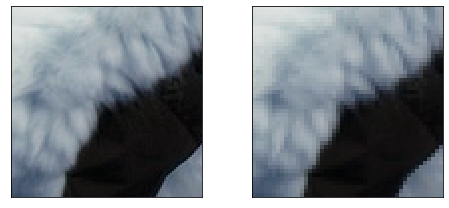

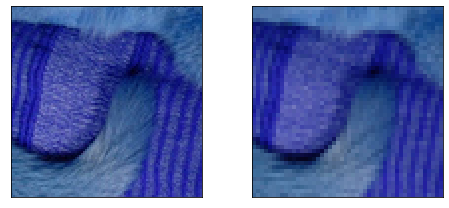

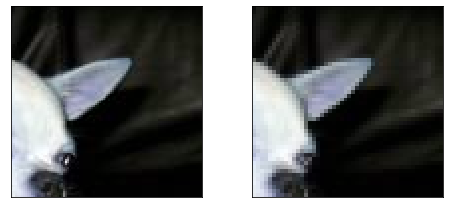

In [15]:
batch_lr_img, batch_hr_img = next(iter(train_gen))

show_num = 3
for i in range(len(batch_hr_img[:show_num])):
    utils.show_batch_imgs(idx=i, demo_ori_img=batch_hr_img[:show_num], demo_lr_img=batch_lr_img[:show_num])


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 93 steps
Epoch 1/3
93/93 [==============================] - 20s 210ms/step - loss: 0.4247 - SSIM: 0.0446
Epoch 2/3
74/93 [======================>.......] - ETA: 3s - loss: 0.1033 - SSIM: 0.3348

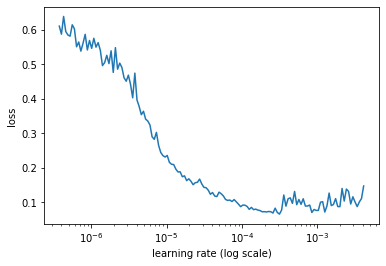

In [7]:
edsr_model = models.edsr(scale=scale, num_filters=64, num_res_blocks=8, res_block_scaling=None)
edsr_model.compile(optimizer=Adam(lr=0.001), loss='mae',  metrics=[losses.SSIM])

lr_finder = lr_finder.LRFinder(edsr_model)
lr_finder.find_generator(generator=train_gen, start_lr=1e-07, end_lr=10, epochs=3)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)


In [20]:
 
edsr_model = models.edsr(scale=scale, num_filters=64, num_res_blocks=8, \
                         res_block_scaling=None, input_shape=(crop_size, crop_size, 3))
edsr_model.load_weights('EDSR_MAE_lr_decay.h5')

img_size = int(crop_size*scale)
HR = Input((img_size, img_size, 3), name = 'HR')
LR = Input((crop_size, crop_size, 3), name = 'LR')
SR = edsr_model(LR)
    
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

vgg = VGG16(include_top=False, weights='imagenet', input_tensor=Lambda(utils.vgg_preprocess_input)(HR))

for l in vgg.layers: 
    l.trainable = False

58892288/58889256 [==============================] - 23s 0us/step


In [27]:
# get perceptual\content outputs
def get_output(model, layer_name): 
    return model.get_layer('block{}_conv2'.format(layer_name)).output

vgg_content = Model(HR, [get_output(vgg, output) for output in [3, 4, 5]], name = 'VGG16')
vgg1 = vgg_content(HR) # to extract features of HR
vgg2 = vgg_content(SR) # to extract features of SR

# Perceptual Loss
loss_cont = Lambda(losses.content_loss, name = 'Content')(vgg1+vgg2)
model = Model([LR, HR], [SR, loss_cont])
multi_losses = ['edsr', 'Content']
weights = [1., 1.]

checkpoint = ModelCheckpoint(filepath = 'sr_multi_loss_x{}.h5'.format(scale), 
                               save_best_only=True, save_weights_only=True,
                               monitor = 'val_loss')
 
opt = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[930, 2000], values=[1e-4, 5e-5, 1e-6]))
model.compile(optimizer=opt, loss = {loss : 'mae' for loss in multi_losses}, 
              loss_weights = weights, metrics={'edsr' : losses.ssim})
 

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
LR (InputLayer)                 [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
edsr (Model)                    (None, 192, 192, 3)  779011      LR[0][0]                         
__________________________________________________________________________________________________
HR (InputLayer)                 [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
VGG16 (Model)                   [(None, 48, 48, 256) 12354880    HR[0][0]                         
                                                                 edsr[1][0]                 

In [17]:

train_gen = data_generator.DataGenerator(img_path_list=train_img_path, crop_size=crop_size, 
                                         batch_size=batch_size, scale=scale, shuffle=True,
                                         crop=True, flip=False, multi_losses=True)

val_gen = data_generator.DataGenerator(img_path_list=val_img_path, crop_size=crop_size,
                                       batch_size=batch_size, scale=scale, shuffle=True, 
                                       crop=True, flip=False, multi_losses=True)


log_filename = datetime.now().strftime("%Y-%m-%d_%H:%M:%S") + 'EDSR_MAE_lr_decay_fintuned.log'
log_path = os.path.join('/work/logs', log_filename) 
csv_logger = CSVLogger(log_path, separator=',', append=False)

callbacks_list = [checkpoint, csv_logger]
model.fit(train_gen, validation_data=val_gen, callbacks=callbacks_list, epochs=epochs)

Train for 93 steps, validate for 24 steps
Epoch 1/30
93/93 [==============================] - 27s 294ms/step - loss: 0.7576 - edsr_loss: 0.0251 - Content_loss: 0.7325 - edsr_ssim: 0.8430 - val_loss: 0.7351 - val_edsr_loss: 0.0242 - val_Content_loss: 0.7110 - val_edsr_ssim: 0.8387
Epoch 2/30
93/93 [==============================] - 25s 270ms/step - loss: 0.7146 - edsr_loss: 0.0245 - Content_loss: 0.6900 - edsr_ssim: 0.8448 - val_loss: 0.7138 - val_edsr_loss: 0.0243 - val_Content_loss: 0.6894 - val_edsr_ssim: 0.8454
Epoch 3/30
93/93 [==============================] - 25s 269ms/step - loss: 0.6904 - edsr_loss: 0.0247 - Content_loss: 0.6656 - edsr_ssim: 0.8440 - val_loss: 0.6773 - val_edsr_loss: 0.0242 - val_Content_loss: 0.6531 - val_edsr_ssim: 0.8477
Epoch 4/30
93/93 [==============================] - 25s 270ms/step - loss: 0.6619 - edsr_loss: 0.0245 - Content_loss: 0.6373 - edsr_ssim: 0.8449 - val_loss: 0.6597 - val_edsr_loss: 0.0241 - val_Content_loss: 0.6356 - val_edsr_ssim: 0.8462
Ep

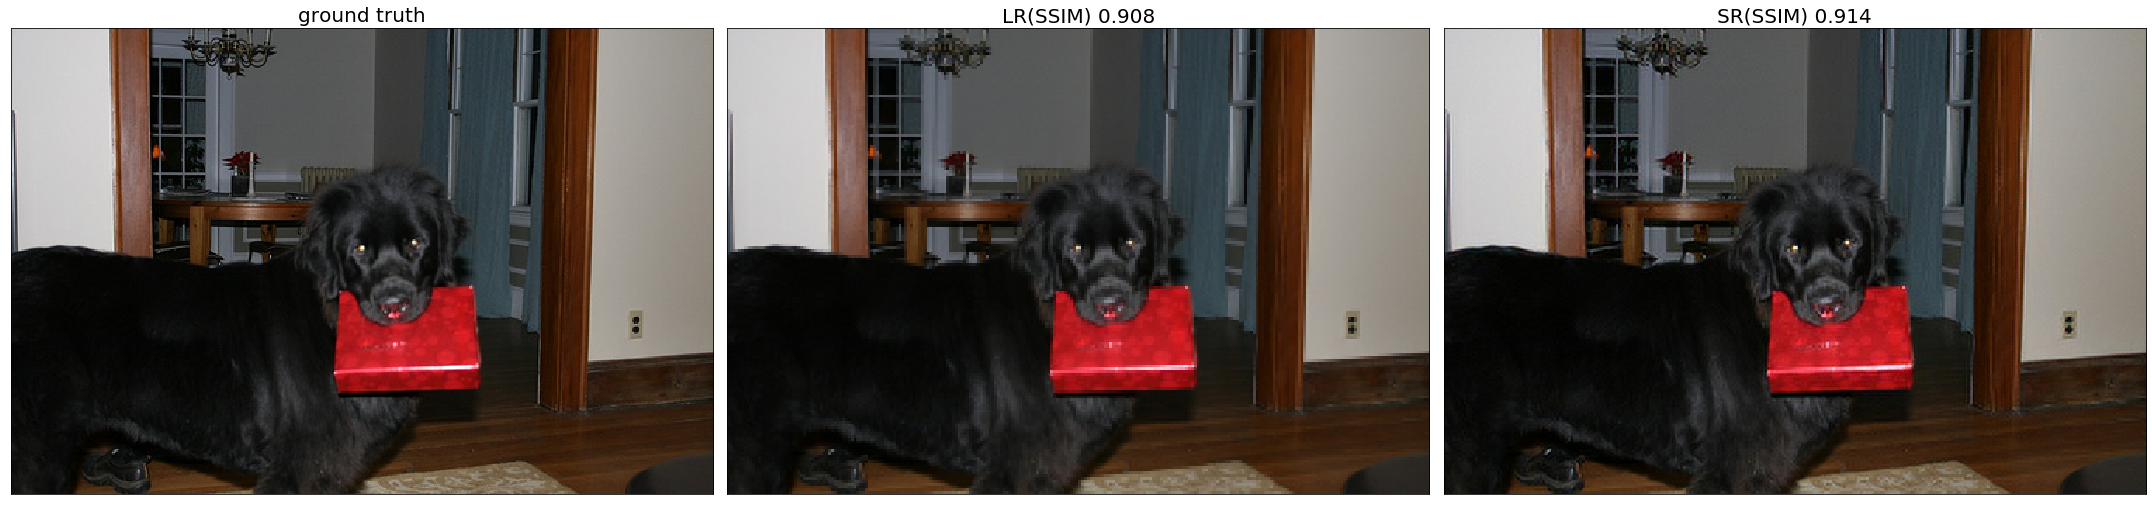

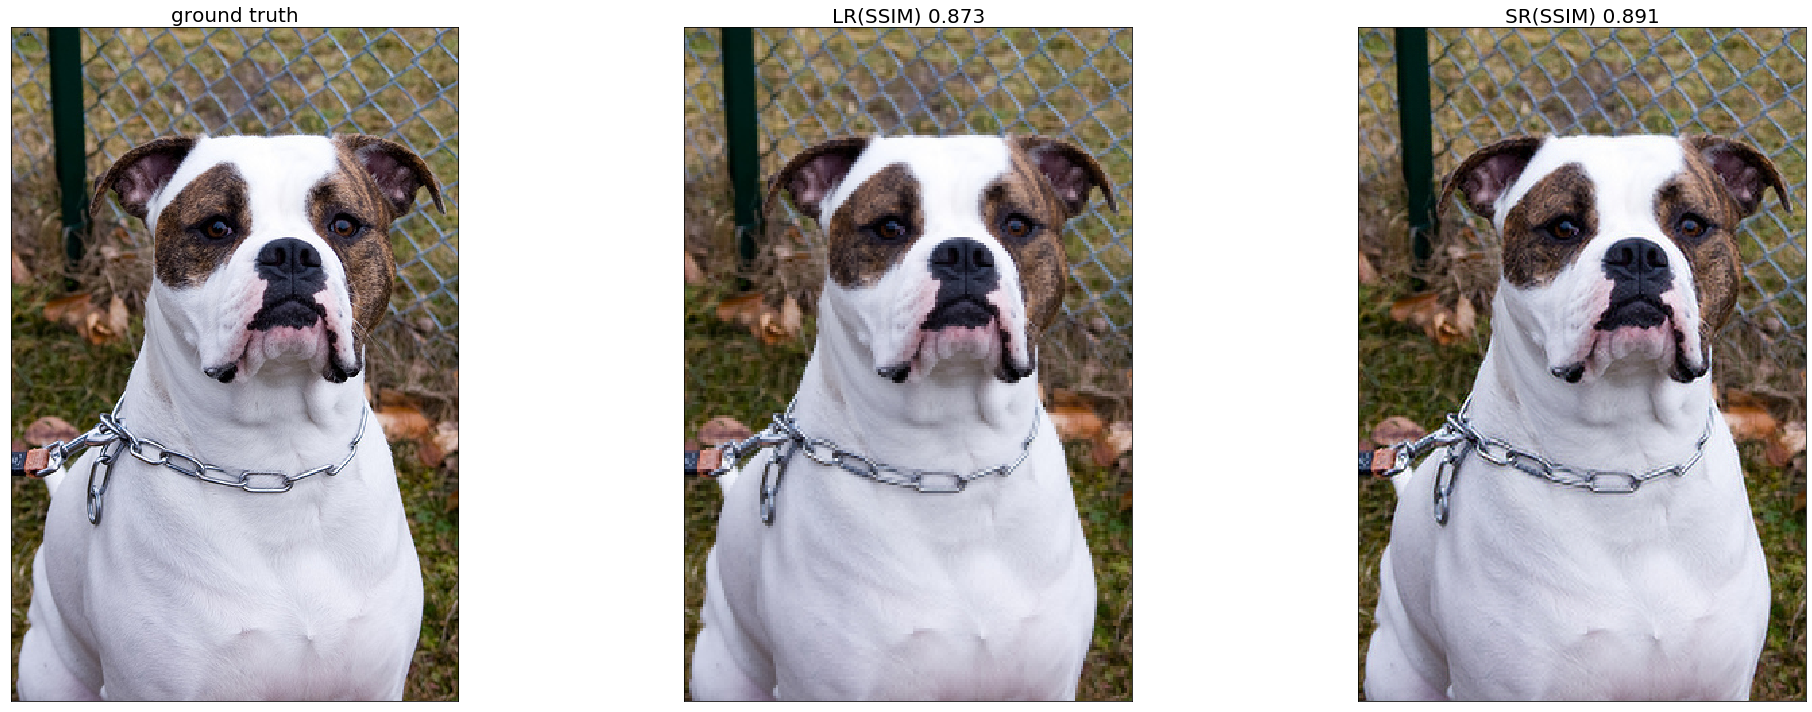

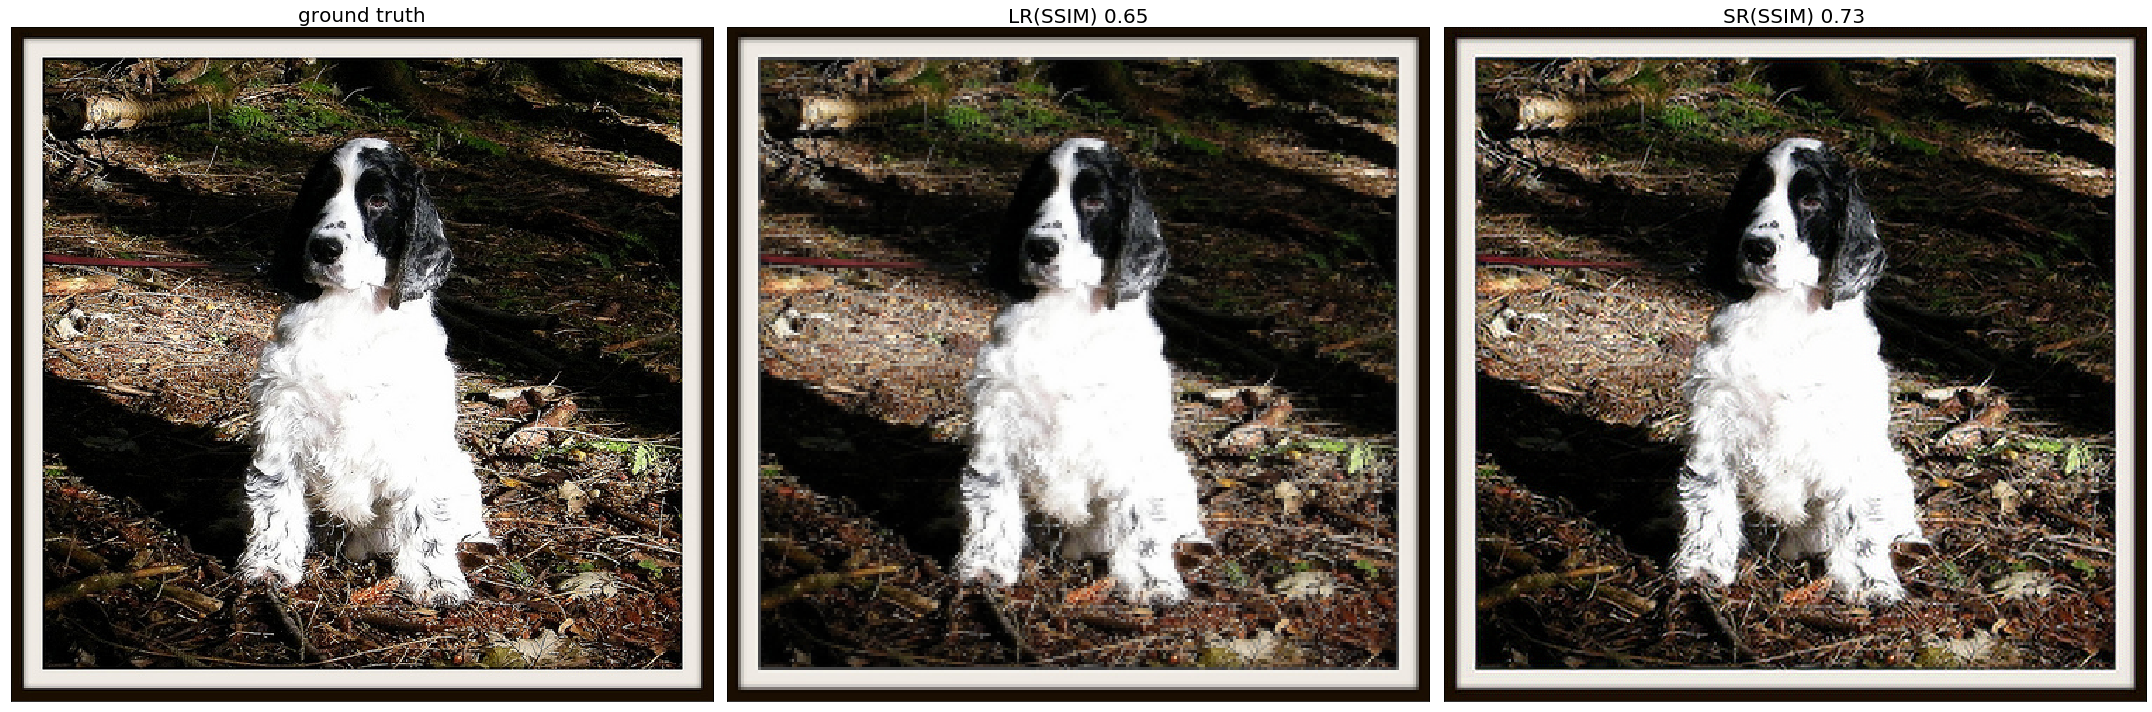

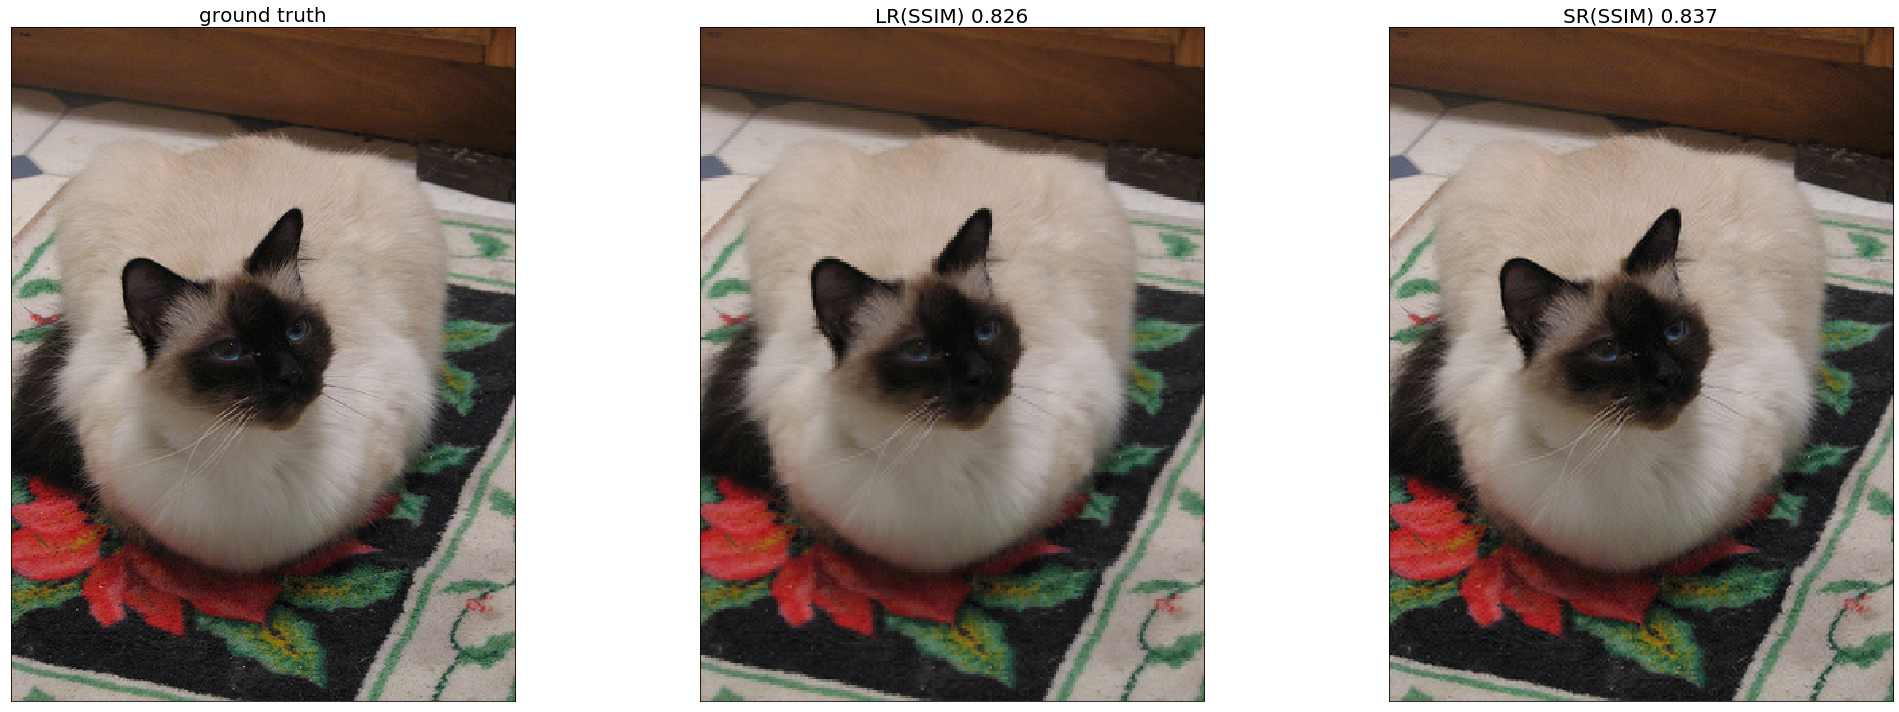

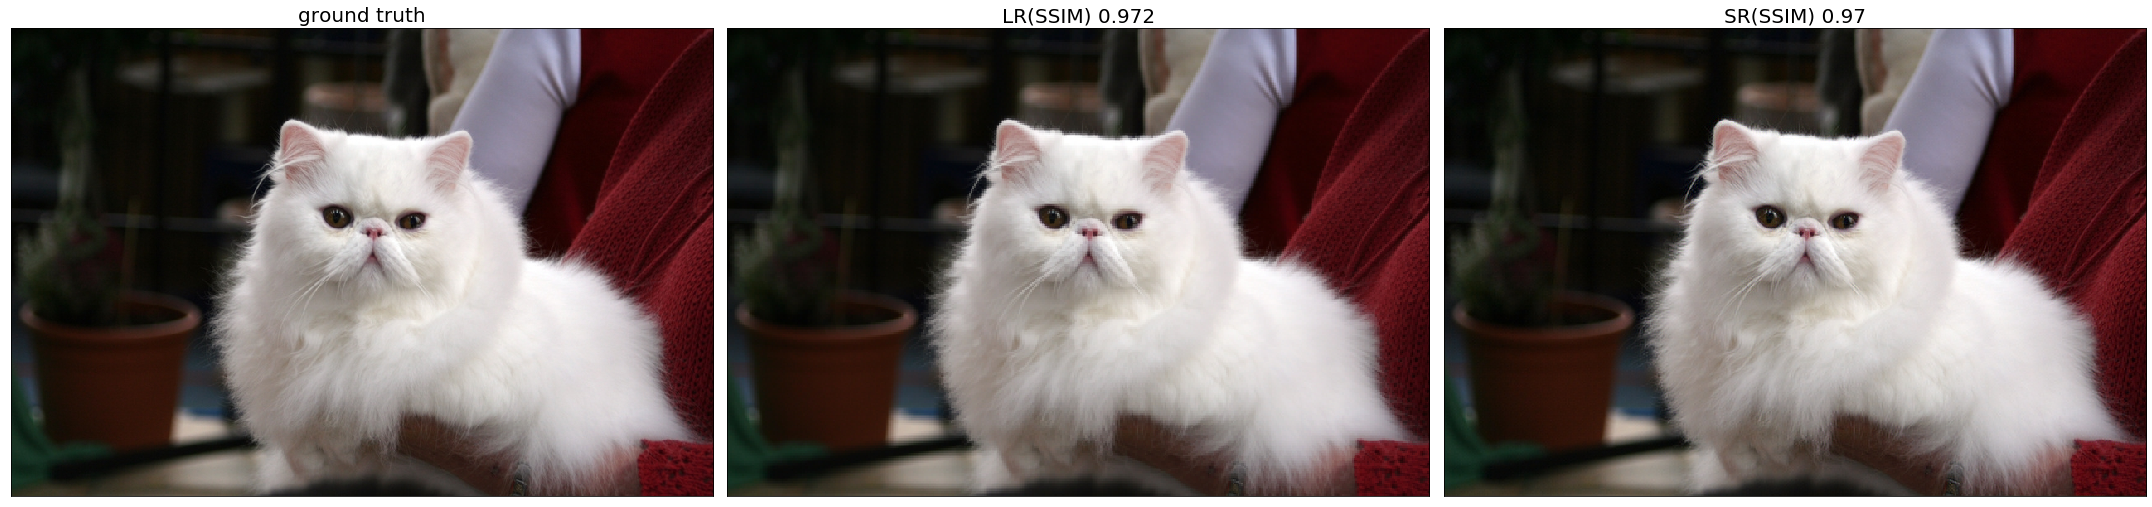

In [20]:
edsr_model.save_weights('test_multiloss_higher_layer_content_finetuned_multilosses.h5')
trained = models.edsr(scale=scale, num_filters=64, num_res_blocks=8, res_block_scaling=None)
trained.load_weights("test_multiloss_higher_layer_content_finetuned_multilosses.h5")

utils.predict_and_show(val_img_path[:5], trained, 2, multi_255=True)


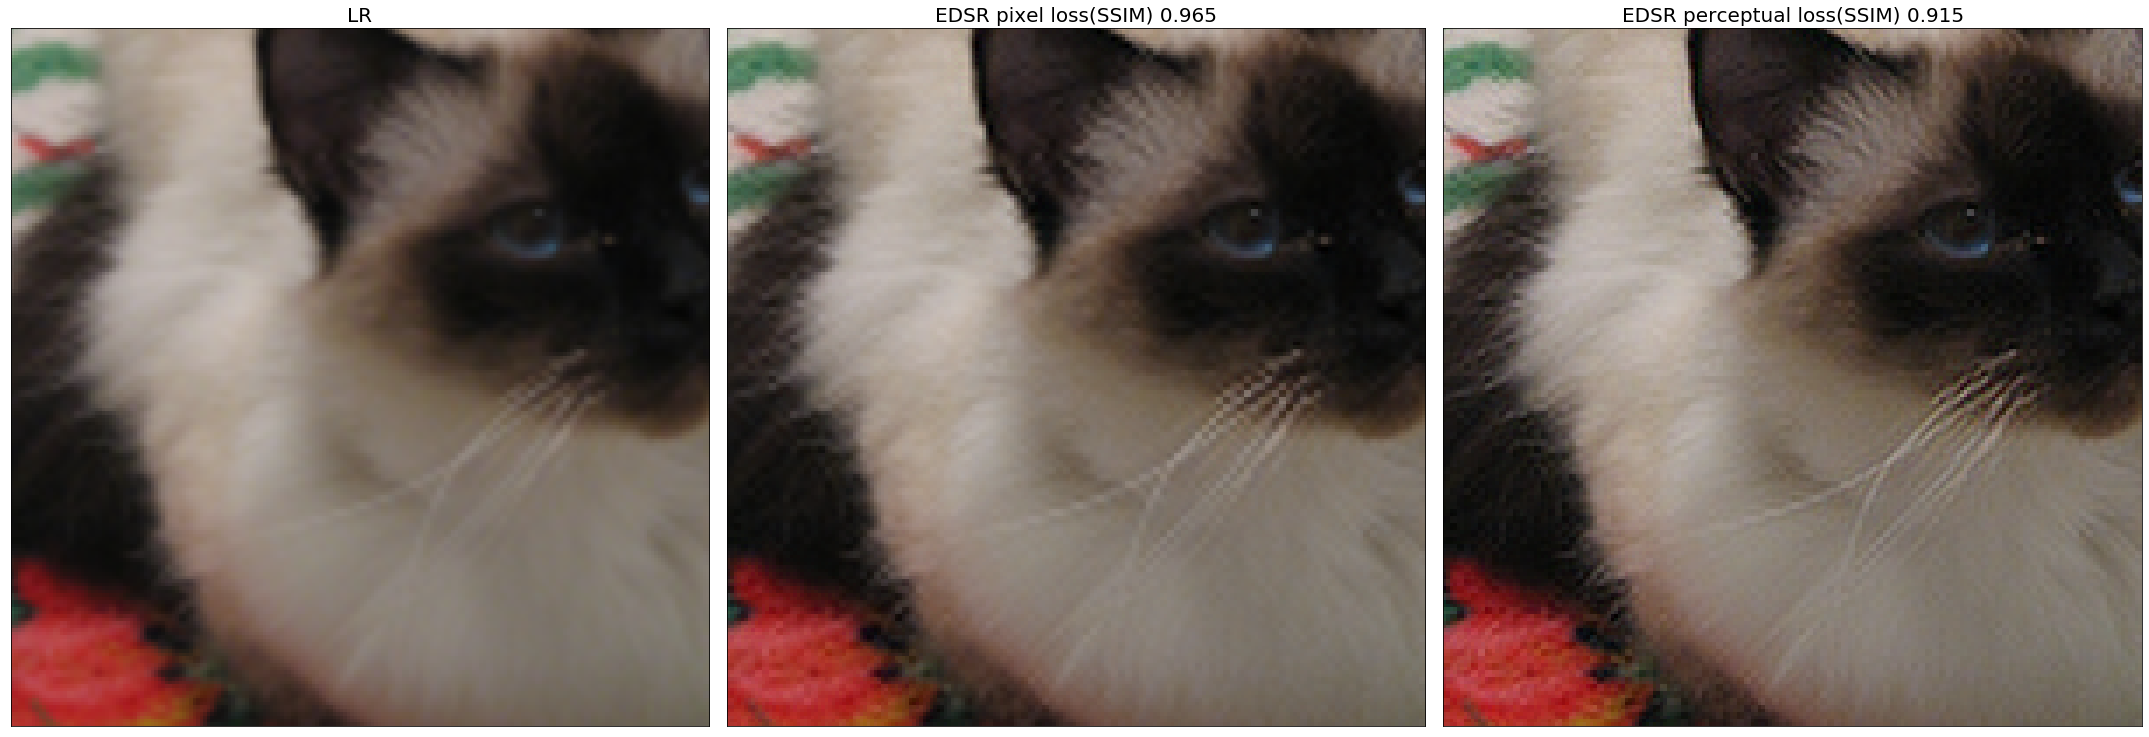

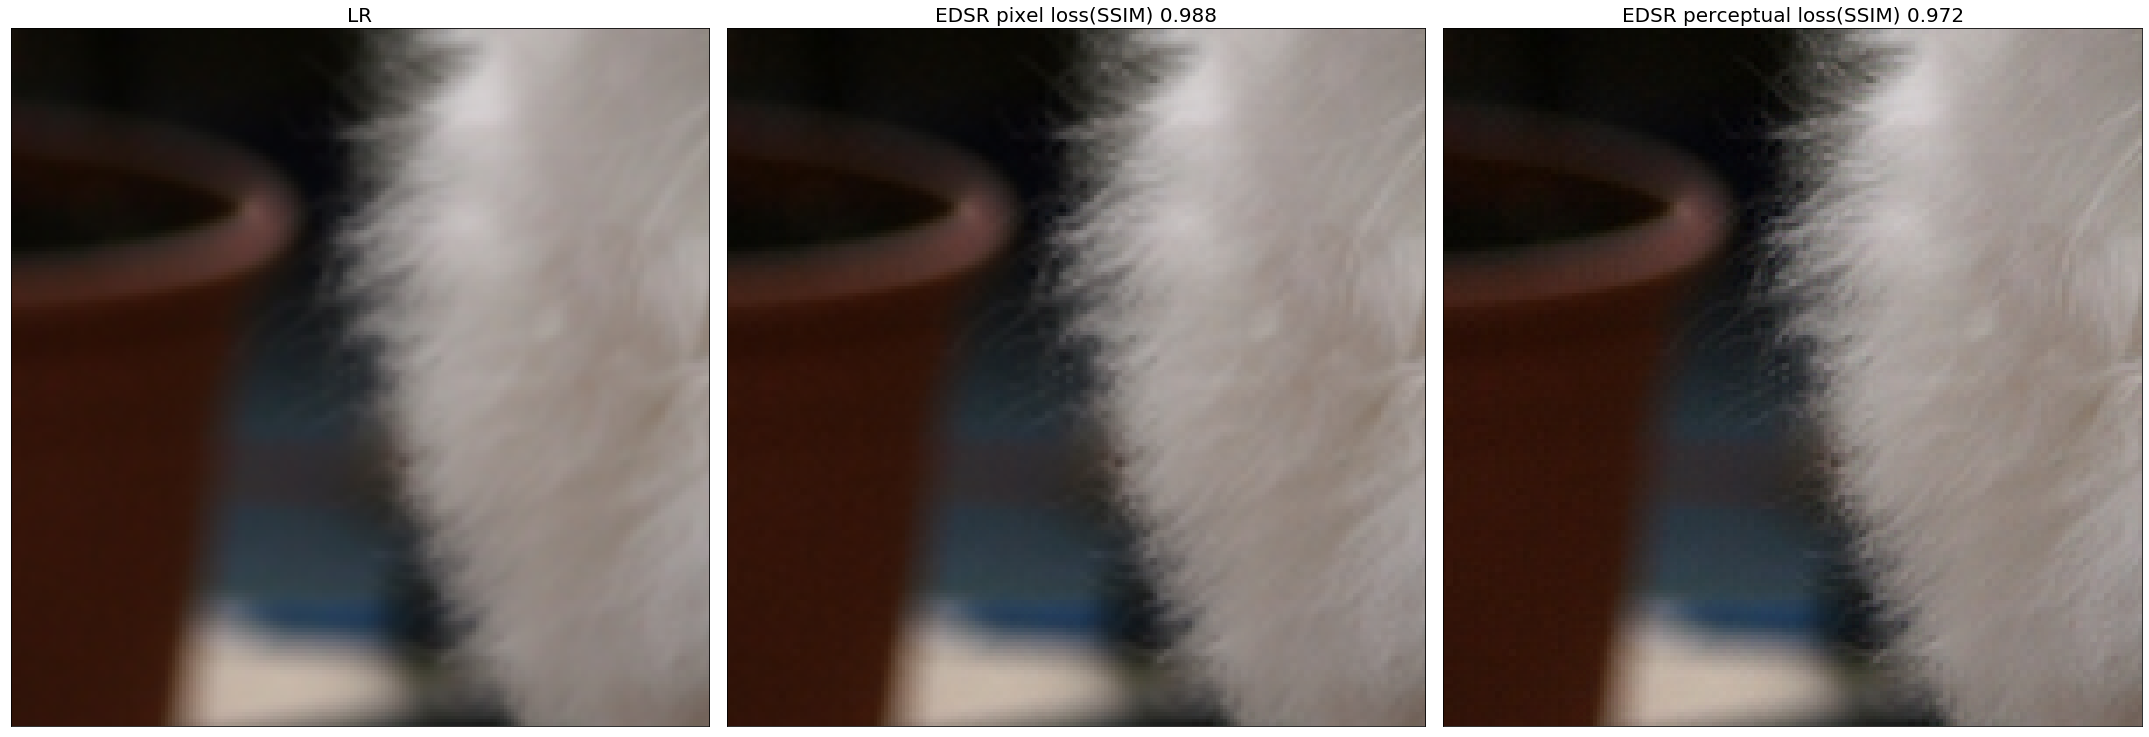

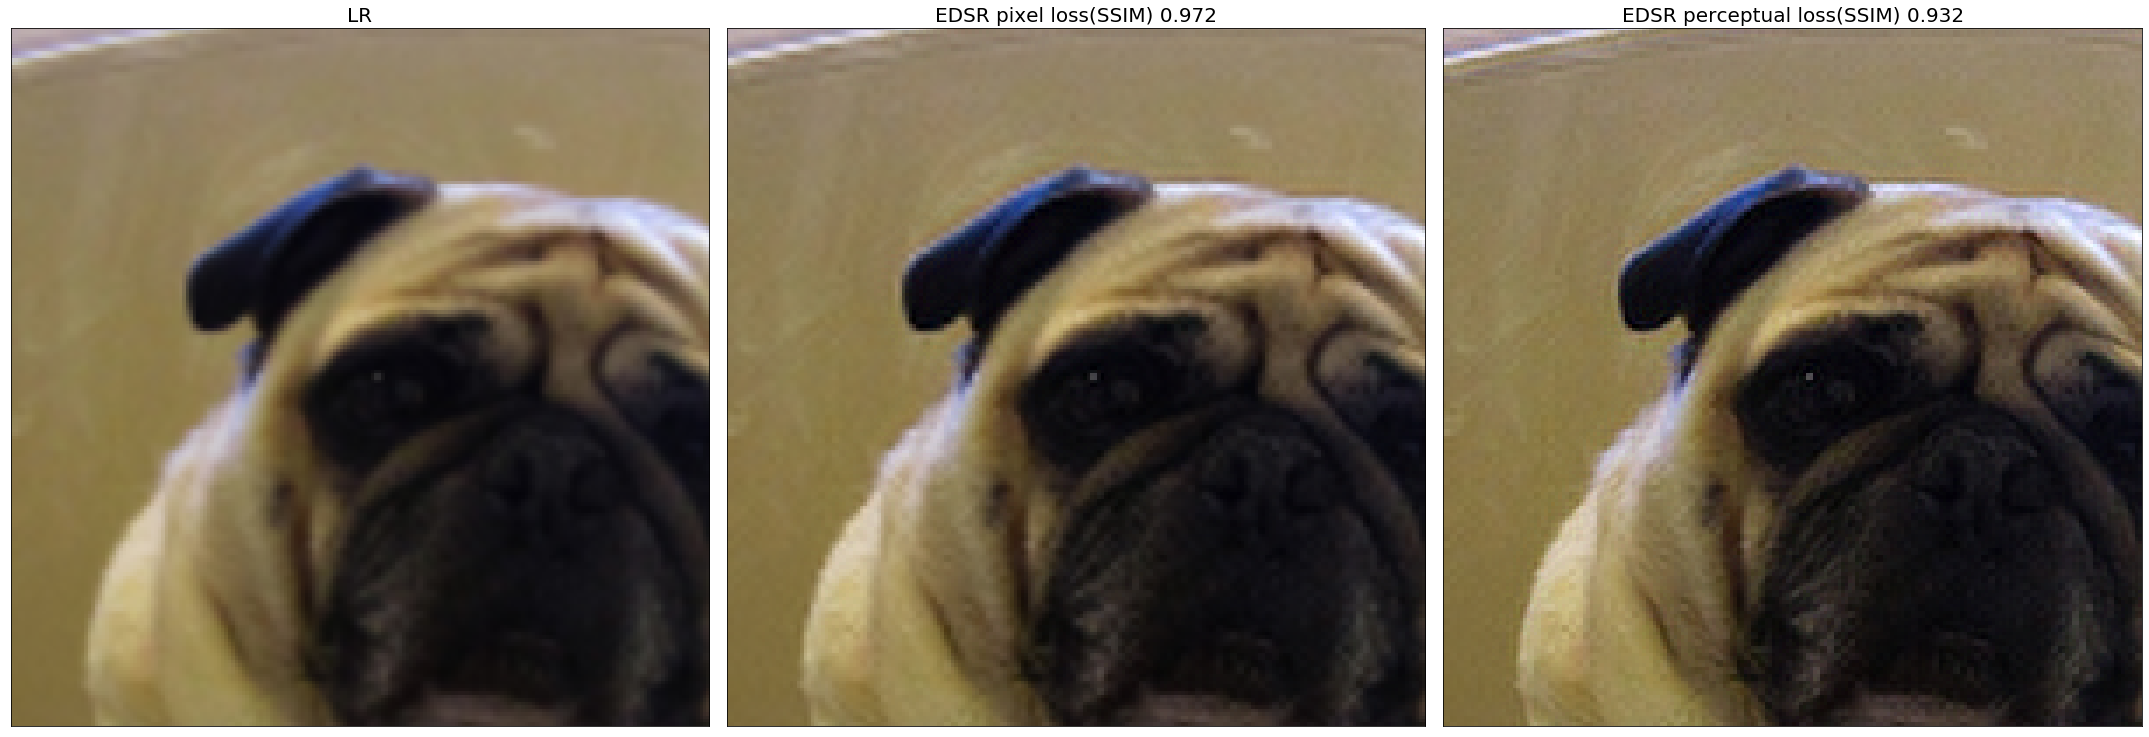

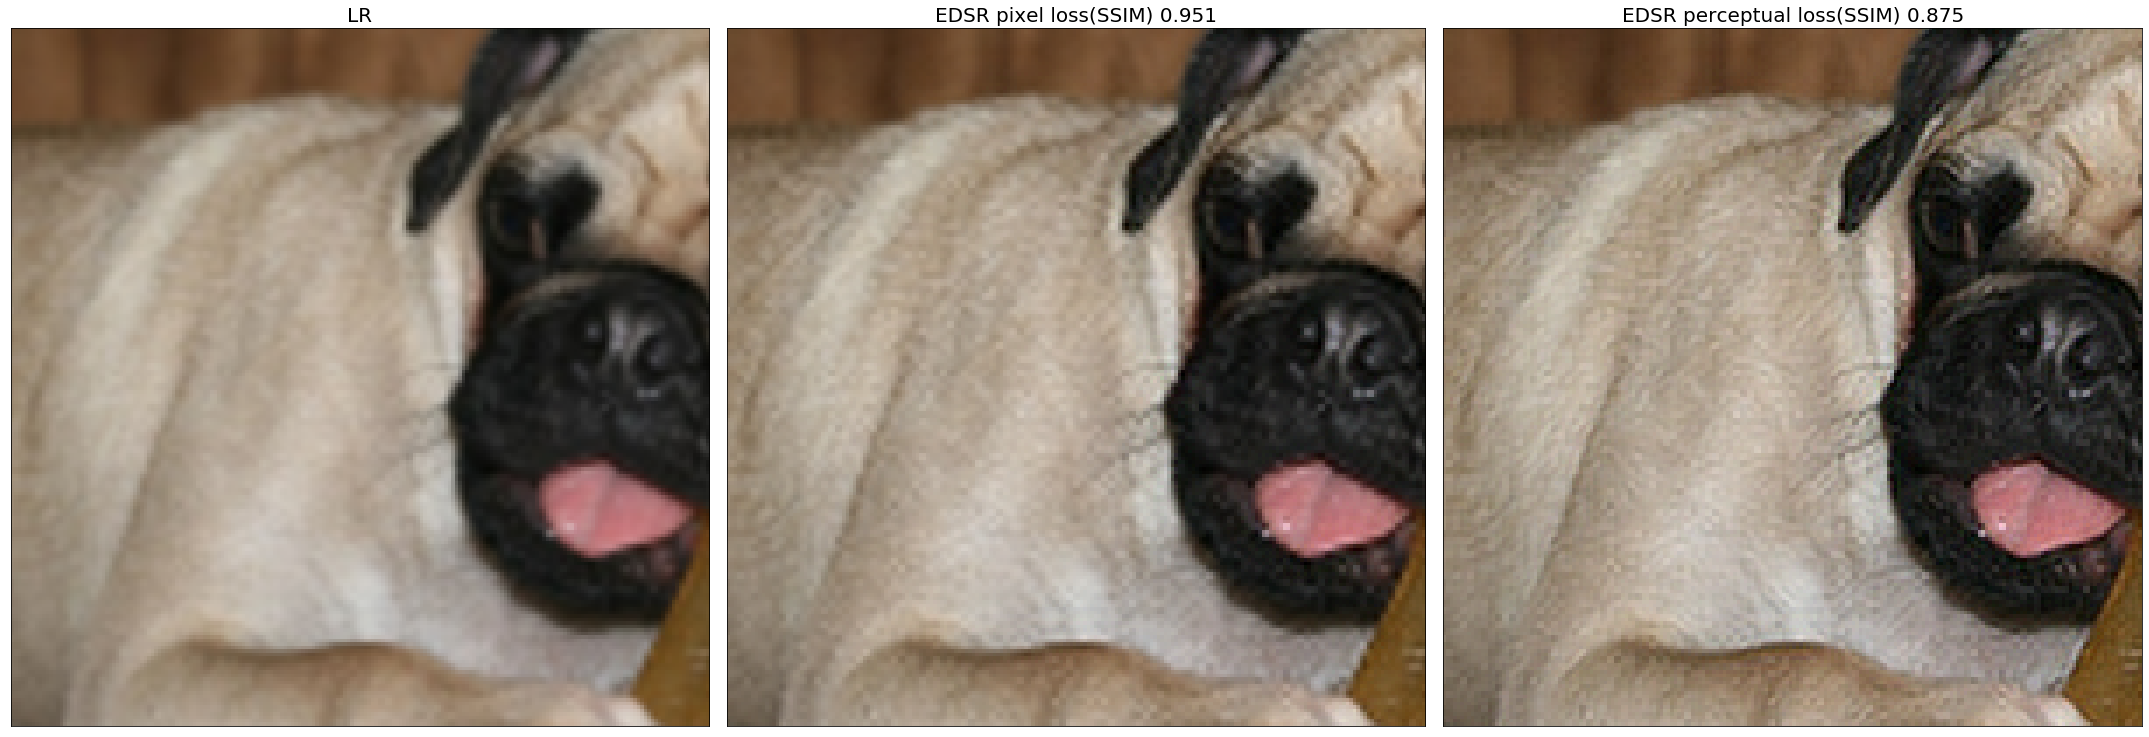

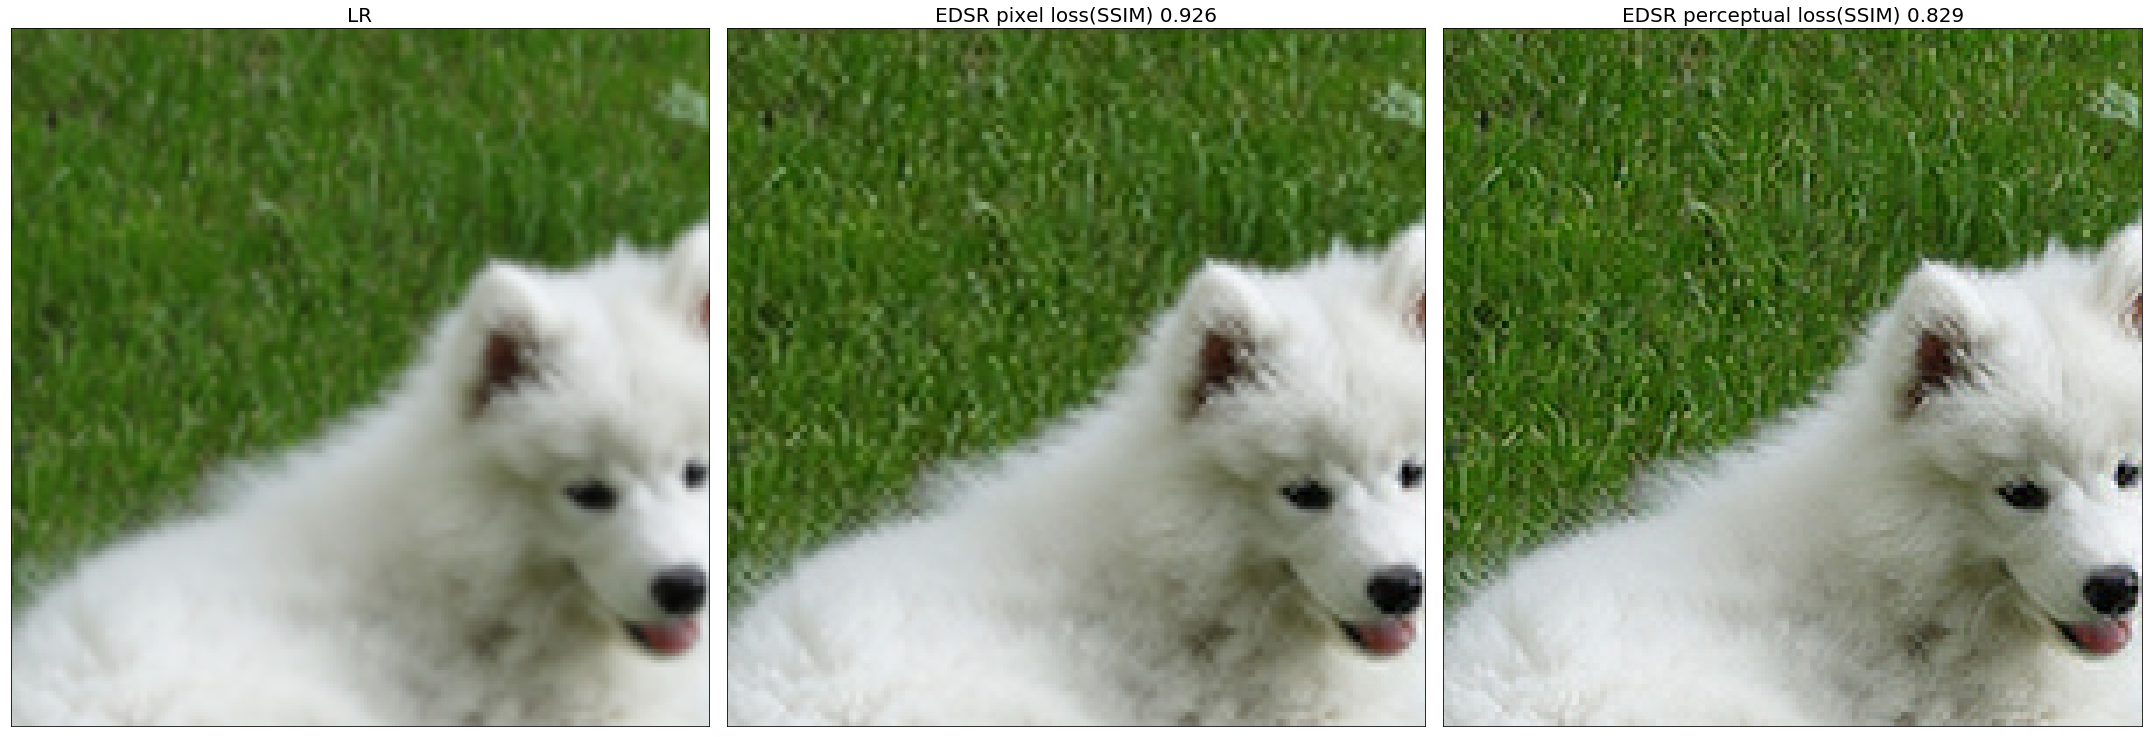

In [10]:

model1 = models.edsr(scale=scale, num_filters=64, num_res_blocks=8, res_block_scaling=None)
model1.load_weights('EDSR_MAE_lr_decay.h5')

model2 = models.edsr(scale=scale, num_filters=64, num_res_blocks=8, res_block_scaling=None)
model2.load_weights("test_multiloss_higher_layer_content_finetuned_multilosses.h5")

utils.compare_two_models(val_img_path[3:8], model1, model2, scale, SRCNN=False, multi_255=True, show_patch=True)
